## RANDOM FOREST

In [1]:
import scipy.stats as stats
import csv as csv
import numpy as np
import pandas as pd
import seaborn as sns
import fnmatch
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Bagging
Случайные объекты выборки

In [2]:
n = 10
np.random.randint(1, n+1, n)

array([ 8, 10,  5,  9,  5,  8,  5,  8,  4, 10])

In [3]:
res = 1 - 1 / np.e
print('Вероятность элемента попасть в  выборку =', res)

Вероятность элемента попасть в  выборку = 0.6321205588285577


### Random Subspace Method, Feature bagging
Случайные признаки для каждого дерева

### Совмещаем обе идеи => Random Forest
ЛЗ вектора здесь не оч, но не суперплохи

Какие гиперпараметры настраивать в Случайном лесе?
1. n_estimators - число деревьев (10 - мало!)
2. n_jobs=-1 (обеспечивает максимальную скорость обучения)
3. criterion = 'gini' (можно и энтропию:; CV)
4. #### max_depth = None (подбирается кросс-валидацией)
5. min_samples_split = 2 (минимальное число объектов для разделения; надо подбирать с помощью CV)
6. min_samples_leaf = 1 (минимально число объектов в вершине; CV)
7. #### max_features = 'auto' (sqrt(d) для классификации с d признаками; СV)


### Практика

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.cross_validation import train_test_split

C:\Users\Максим\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
df = pd.read_csv('train.csv')
df.head() # это вся выборка

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
y = df['Survived']
del df['Survived']
df['Age'].fillna(df['Age'].mean(), inplace=True)
feature_names = ['Sex', 'Age', 'SibSp', 'Pclass', 'Parch', 'Fare']
df = df[feature_names]
df['Sex'] = (df['Sex'] == 'male').astype(int)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, y)

In [8]:
X_train.shape

(668, 6)

In [9]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
print('Accuracy:', accuracy_score(y_test, tree.predict(X_test)))
print('AUC-ROC:', roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1]) )

Accuracy: 0.807174887892
AUC-ROC: 0.803498985801


In [10]:
tree_param ={'max_depth': np.arange(1, 20), 'criterion': ['gini', 'entropy']}
gs_tree = GridSearchCV(DecisionTreeClassifier(), tree_param, scoring='roc_auc' )
gs_tree.fit(X_train, y_train)
print('Accuracy:', accuracy_score(y_test, gs_tree.predict(X_test)))
print('AUC-ROC:', roc_auc_score(y_test, gs_tree.predict_proba(X_test)[:, 1]) )

Accuracy: 0.838565022422
AUC-ROC: 0.866041244084


In [11]:
gs_tree.best_params_

{'criterion': 'entropy', 'max_depth': 4}

In [12]:
gs_tree.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [13]:
gs_tree.cv_results_.keys()

dict_keys(['mean_test_score', 'split2_train_score', 'mean_train_score', 'mean_score_time', 'std_train_score', 'rank_test_score', 'std_test_score', 'std_score_time', 'split1_test_score', 'split1_train_score', 'split0_test_score', 'split0_train_score', 'std_fit_time', 'param_max_depth', 'mean_fit_time', 'param_criterion', 'params', 'split2_test_score'])

In [14]:
crit = np.array(gs_tree.cv_results_['param_criterion'])
depth = np.array(gs_tree.cv_results_['param_max_depth'])
score = np.array(gs_tree.cv_results_['mean_test_score'])

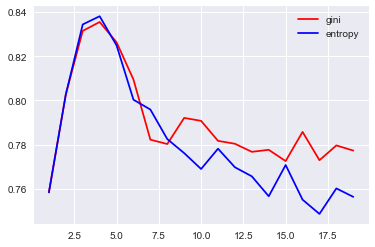

In [15]:
idx = crit == 'gini'
plt.plot(depth[idx], score[idx], c ='r')
idx = crit == 'entropy'
plt.plot(depth[idx], score[idx], c ='b')

plt.legend(['gini', 'entropy'])

In [16]:
rf = RandomForestClassifier(n_estimators=310, n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)
print('Accuracy:', accuracy_score(y_test, rf.predict(X_test)))
print('AUC-ROC:', roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]) )

Accuracy: 0.829596412556
AUC-ROC: 0.866886409736


In [17]:
pd.Series(rf.feature_importances_, index=X_train.columns) # важность признаков по отдельности; не надо увлекаться удалением
#после удаления max_features меняется, сл-но, нужно запустить новую CV

Sex       0.250827
Age       0.268135
SibSp     0.046931
Pclass    0.083941
Parch     0.040033
Fare      0.310133
dtype: float64

In [18]:
rf.oob_score_ # accuracy для не попавших в обучение объектов

0.80538922155688619